# Regional simulation using ERA5-Land forcing

In this tutorial, we will provide a new set of model forcing capability with the ERA5-Land data at 0.1 degree. 

Thanks for the contribution from Alessandro Anav (alessandro.anav@enea.it) from Italian National Agency for New Technologies, Energy and Sustainable Economic Development, Ehsan Jalilvand (<ehsanj@msu.edu>) from Michigan State University, Tzu-Shun Lin (tslin2@ucar.edu) and Zhe Zhang (zhezhang@ucar.edu) from NCAR for providing and testing the pre-processing code.

A written documentation for processing the ERA5-Land forcing is also available: https://github.com/NCAR/hrldas/blob/master/hrldas/docs/README.ERA5

## 1. Generate geo_em domain file
The first step is to create a geo_em file for defining simulation domain. 
This **geo_em** file can be generated from WPS `geogrid.exe` at: https://www2.mmm.ucar.edu/wrf/OnLineTutorial/Basics/index.php


In this tutorial, we will use the geo_em file for the Prairie Pothole Region (PPR) across the US and Canada at 4-km. 

We can check on this file:

`ncview geo_em.d01.nc_ppr` (for example, **HGT_M** variable for terrain height)
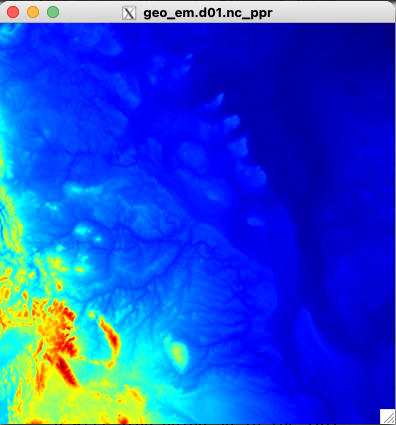

For users interested in other domains in the world, just use the **geogrid.exe** program in WPS to setup a domain file, before generate forcing with **create_forcing.exe**.

## 2. Download ERA5-Land Forcing

Before we start downloading data, it is recommended to create directories for storing the raw and pre-processed data. 

`mkdir ERA5_Land`

`mkdir ERA5_Land/raw`

`mkdir ERA5_Land/extracted`

`cd ERA5_Land/raw`

The ERA5-Land data can be accessed at the Copenicus Climate Data Store:
https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview

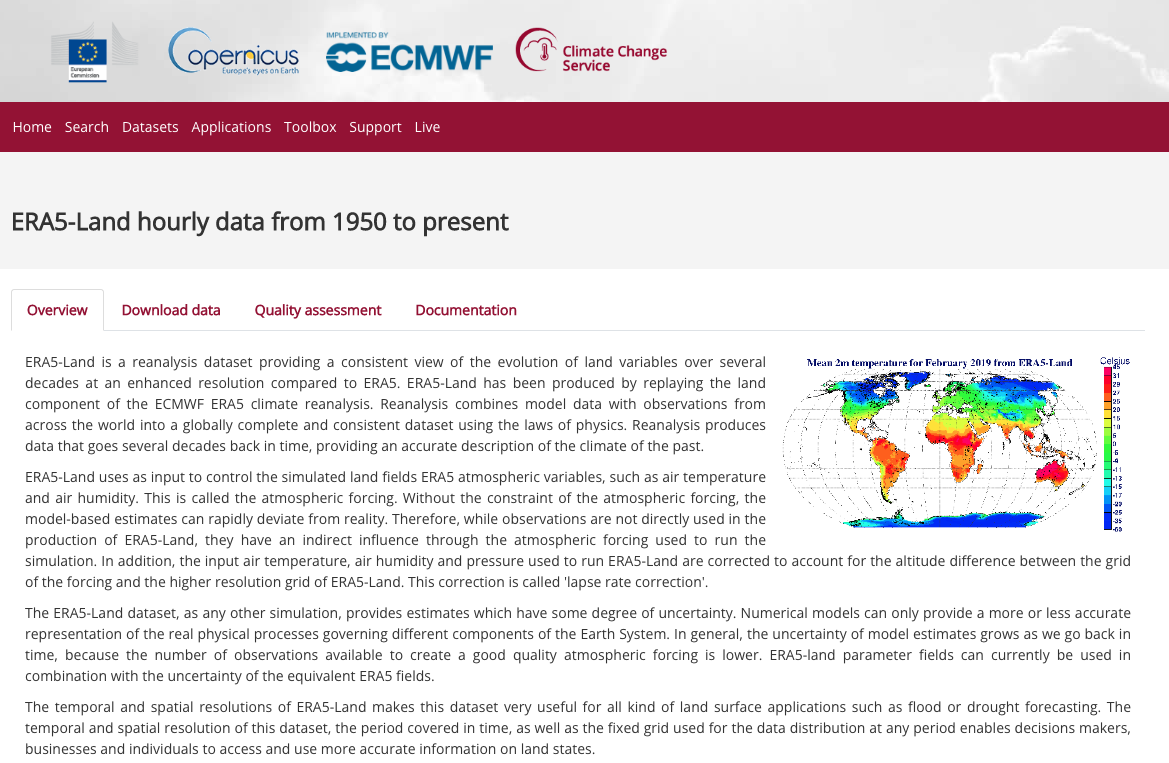

The ERA5-Land data starts from 1950-01-01 to present date, with spatial resolution 0.1 ° x 0.1 ° (native resolution is 9km) and hourly temporal interval.

Note that you will need to **register** and **log in** before downloading data from the Copenicus Climate Data Store.

**Variable**:

At the `Download data` page, select 8 forcing variables, they are:

**2m dewpoint temperature, 2m temperature, surface thermal radiation downwards, surface solar radiation downwards, 10m u-component of wind, 10m v-component of wind, surface pressure, total precipitation**

**Note:** if you want to use initial conditions from ERA5-Land, you will also need to download: **Snow depth water equivalent, volumetric soil water for 4 levels, skin temperature, soil temperature for 4 levels**. (Only needed for the first time step at the start of the simulation, so it would be easier to start a new download only for the initial data).

Two additional parameters are needed, (**geopotential**, converting to height, and the **land-sea mask**), and can be downloaded at:
https://confluence.ecmwf.int/display/CKB/ERA5-Land%3A+data+documentation#ERA5Land:datadocumentation-parameterlistingParameterlistings
These two datasets are provided in GRIB1, GRIB2, and netCDF4 format. I recommend download the netCDF4 format.

**Time**: In this tutorial, for example, we can run 3-day simulation from **1980-01-01**. So select Year 1980, Month January, Day 01-03, Time select all.  

**Geographical area**: select **Whole available region**.

**Format**: select **GRIB**. (Although NetCDF format is available, but it is still experiemental, so we decided to use GRIB format. Also GRIB format require less space)

After all these selection, then you can **Submit Form**.

After downloading the data, we can rename two downloaded files:
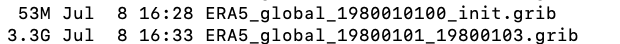

One for 3-day forcing data `ERA5_global_19800101-19800103.grib` and one for the initial data `ERA5_global_1980010100_init.grib`.

## 2.1 Download with CDS-API
The European Climate Data Store (CDS) also provides API request script to assist the data download process

Here is the documentation page on how to install and use CDS API:
https://cds.climate.copernicus.eu/api-how-to

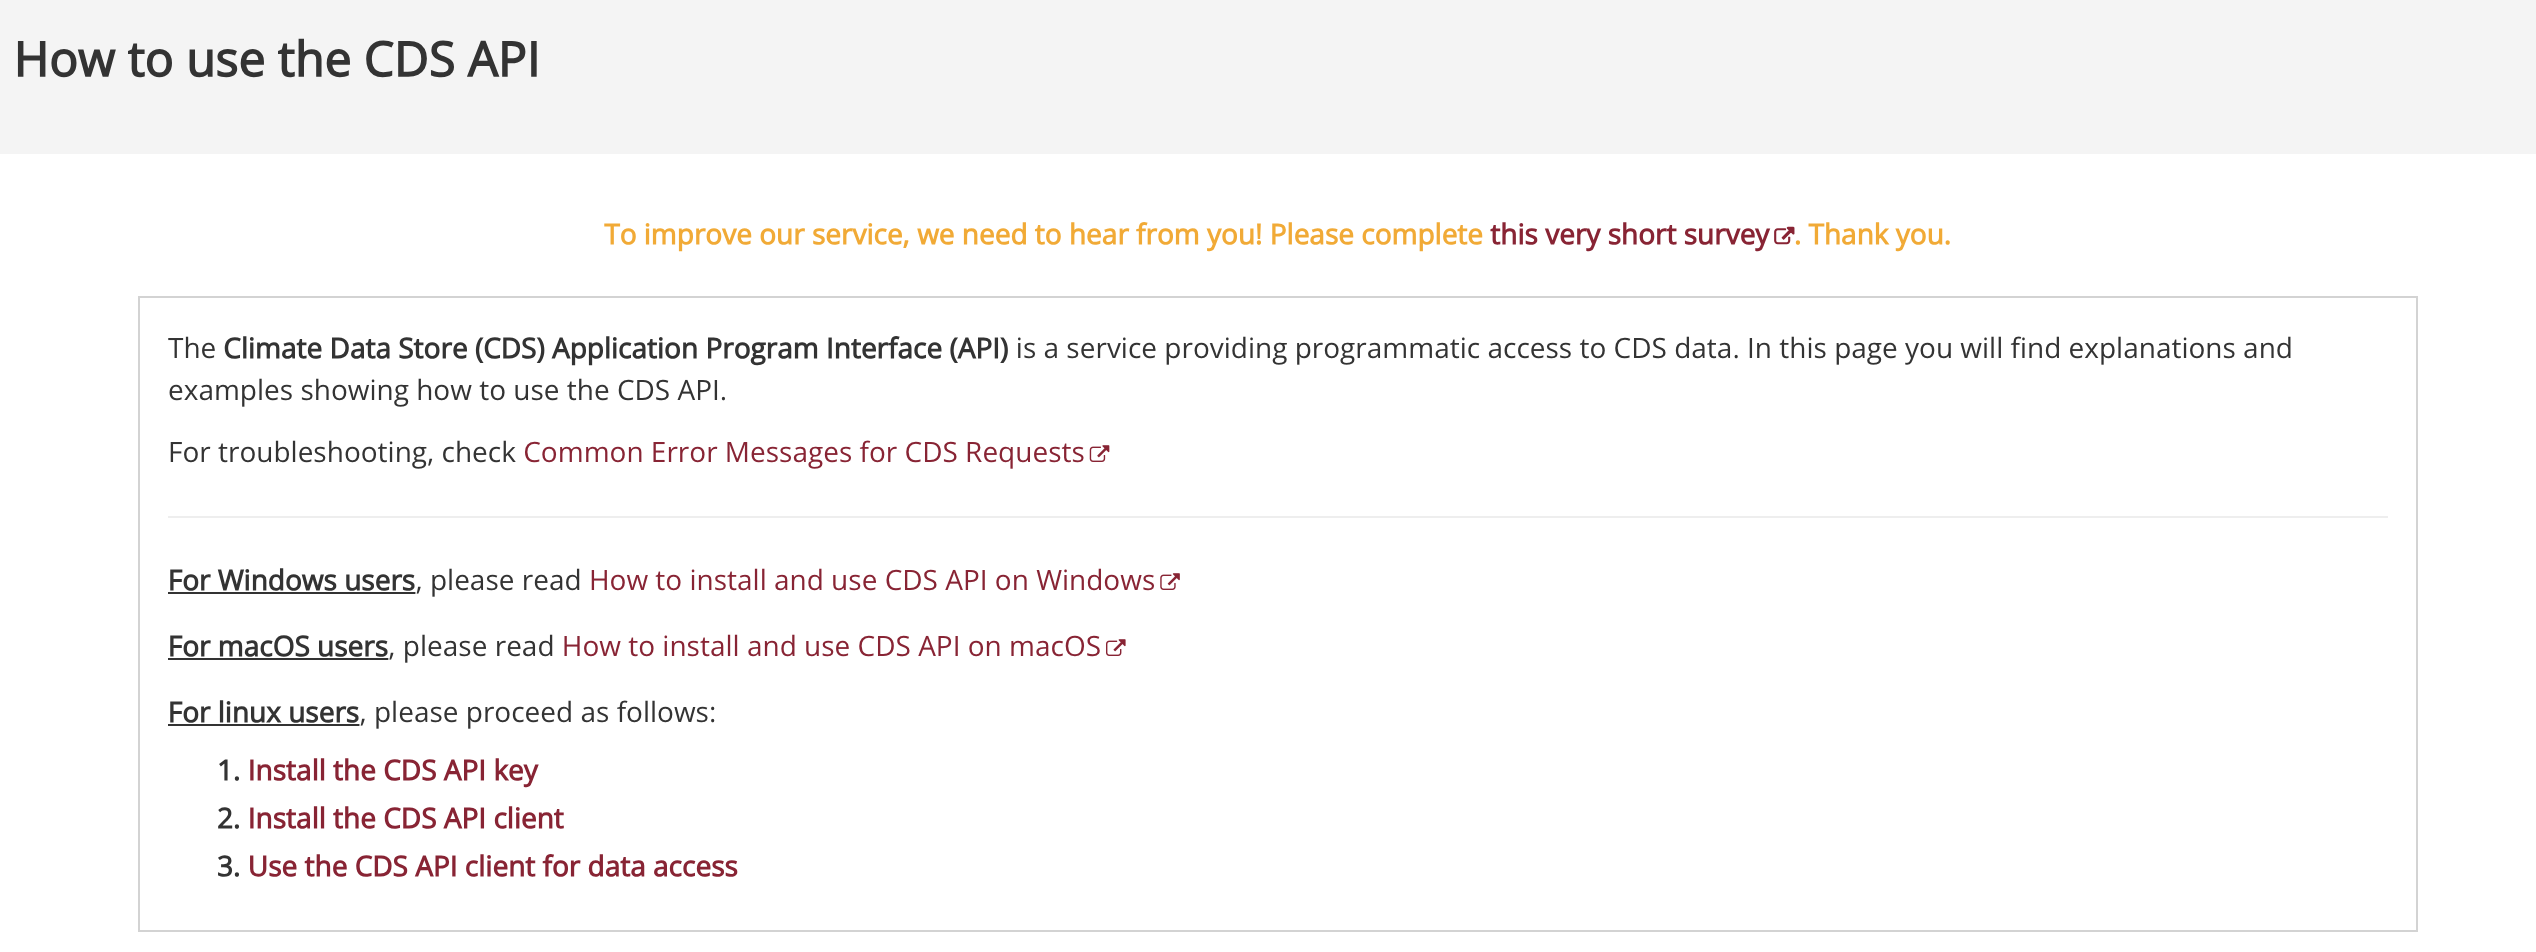

Following the instruction in this page will set up the API linked with your registered CDS account.

After setting up with the CDS API, the following code box will show an example of downloading ERA5-Land data, for three days from 1980-01-01 to 1980-01-03:

In [ ]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-land',
    {
        'variable': [
            '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_dewpoint_temperature',
            '2m_temperature', 'surface_pressure', 'surface_solar_radiation_downwards',
            'surface_thermal_radiation_downwards', 'total_precipitation',
        ],
        'year': '1980',
        'month': '01',
        'day': [
            '01', '02', '03',
        ],
        'time': [
            '00:00', '01:00', '02:00',
            '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00',
            '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00',
            '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00',
            '21:00', '22:00', '23:00',
        ],
        'format': 'grib',
    },
    'download.grib')

### Please note, for running the shell code for pre-processing, an additional last time step before the simulation starting time is required. Therefore, will also need to download 1979-12-31_23:00:00.

## 3. Pre-processing ERA5-Land forcing data

Now, after downloading the forcing data, we can go the pre-processing step in: 

`cd ./hrldas/HRLDAS_forcing/run/examples/ERA5/`

**Prepare_ERA5-Land_Forcing.sh**: this extracting program was originaally written with python, while users might have encountered issues with discrepancies between python version 2 and 3. Thus, we decide to adapt to a shell code `Prepare_ERA5-Land_Forcing.sh` provided by Alessandro Anav (alessandro.anav@enea.it), that is also faster and simpler in extracting ERA5-land forcing data in one step. We really appreciate the user's contribution!

**Note**: You will need **eccodes** module, **cdo** module, and **shell** program for this step. Check with your IT staff to see if they are already installed and you need to load them, for example, `module load eccodes`. 

Or you will need to install eccodes: An installation guide for eccodes is provided by ECMWF at this link:
https://confluence.ecmwf.int/display/ECC/ecCodes+installation
and also see this discussion page provided by Ehsan Jalilvand (ehsanj@msu.edu):
https://github.com/NCAR/hrldas/discussions/111

### 3.1 Extract individial variables from the ERA5-Land GRIB files

In **Prepare_ERA5-Land_Forcing.sh**, users only need to modify one place to successfully run the shell code, that is to provide the input file names, shown below. 

**Note**: After testing the code, the code can deal with data contained in one single file, not necessary to be one year exact, can also be days, months, etc. Running the code can extract all these the data timesteps contained in this one single file

In [ ]:
### Example code in Prepare_ERA5-Land_Forcing.sh to extract all variables from ERA5-land data

#################################################################################################
#                                                                                               #
#                                        USER DEFINED INPUT FILES                               # 
#                                                                                               #
#################################################################################################

year=1980
INFILE=/fas4/anav/INPUTS/ERA5_for_Noah-MP/YEARLY/ERA5-Land_Noah-MP_$year.grb

let last_year=$year-1
PREVIOUS_YEAR=/fas4/anav/INPUTS/ERA5_for_Noah-MP/YEARLY/ERA5-Land_Noah-MP_$last_year.grb

### 3.2 extract the initial-only fields

**extract_era5_init.py**: extract the initial-only fields (**SKT, SD, STL1-4, SWV1-4**) from the ERA5-Land GRIB output files. 

**Note**: in the ERA5-Land data documentation (https://codes.ecmwf.int/grib/param-db/?id=141), the variable snow depth water equivalent (SWE) is with short name **sd**. It is easy to get confused with another variable snow depth that has a short name **sde**. 

The model requires snow water equivalent, hence **sd** is the correct variable to download and process. 


`yr = "80"`

`date = "0101"`

`cc = "19"`

......

`infile = data_dir + "ERA5_global_1980010100_init.grib"`

Change the date of initialization and run the script one time. The files should appear in the `./extract/INIT/` directory.

`ls -lh ./extract/INIT/*1980*`

You can find the extracted initial files in the INIT folder.

**Note**: this step is not necessary unless you want to intialize using the ERA5-Land data. Other alternative way to initialize, you can use WRF model output soil moisture, soil temperautre, SWE too. 

### 3.3 Run the HRLDAS pre-processor code.

At this point, you should have all the ERA5-Land data extracted into different directories at `./extract/`. Now it's finally time to run the first step of the HRLDAS.

`cd ./root_path/hrldas/hrldas/HRLDAS_forcing/`

You will need to put `geo_em.d01.nc` file and the geopotential and land-sea mask file from ERA5-Land into the `/HRLDAS_forcing/` folder.


In the `run/examples/ERA5/` directory there is a `namelist.input.ERA5` file that is consistent with the ERA5 procedure described above. You can modify this file for your case and place it in the pre-processor run directory:

`cp ./run/examples/ERA5/namelist.input.ERA5 .`

`ls `: you will find these files in the folder.

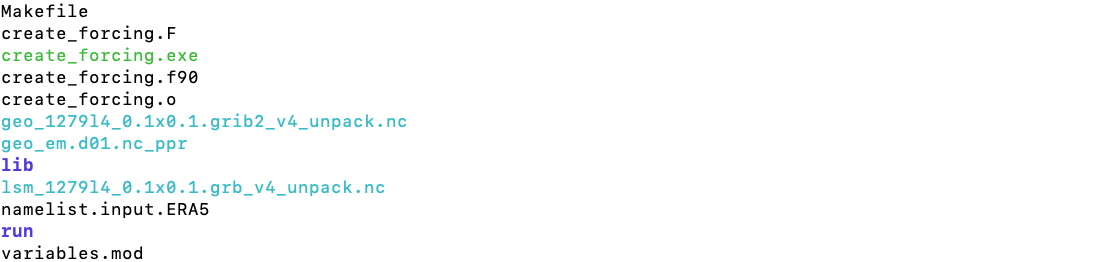

#### 3.3.1 Modify the namelist

Modifying the `namelist.input.ERA5` to your case. The following is a short description of each line in the file. A longer description is available in `README.namelist`.

`STARTDATE = "1980-01-01_00"`

`ENDDATE   = "1980-01-03_00"`

......

`FORCING_TYPE = "ERA5"`

`FULL_IC_FRQ  = 0` # set this option = 0 if you want to use ERA5-Land data for initialization, then will create a HRLDAS_setup file. set to -1, will not create HRLDAS_setup file from the ERA5-Land data.

`geo_em_flnm        = "./geo_em.d01.nc_ppr"`

`Zfile_template     = "./geo_1279l4_0.1x0.1.grib2_v4_unpack.nc"`

`LANDSfile_template = "./lsm_1279l4_0.1x0.1.grb_v4_unpack.nc"`

These three entries will control the path of geo_em, ERA5-Land geopotential and land-sea mask.

#### 3.3.2 Run the create_forcing.exe

After modifying the namelist for create_forcing.exe, we can now start to generate ERA5-Land forcing for our regional domain:

`./create_forcing.exe namelist.input.ERA5`

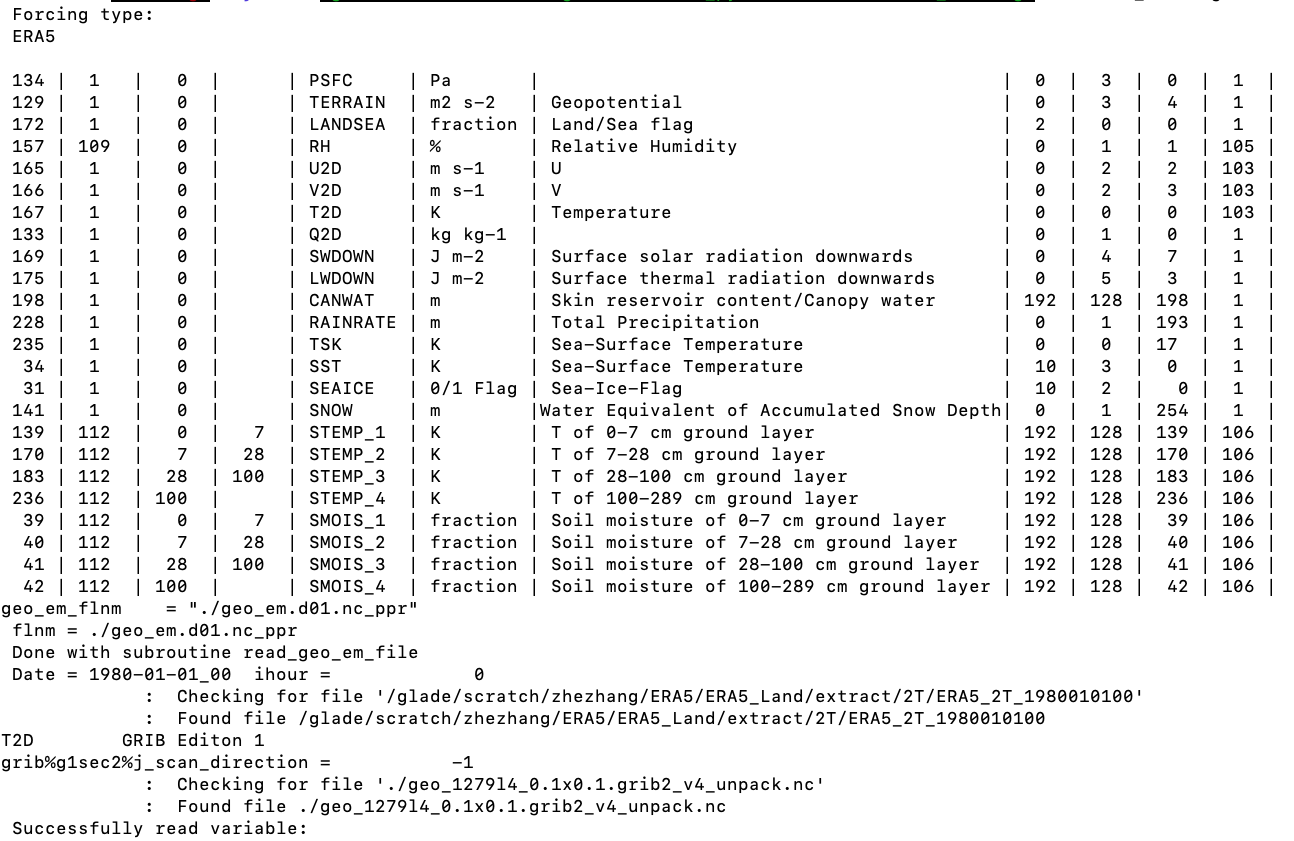

You will find the `create_forcing.exe` program successfully running. 

Then you can find the forcing data generated in the designated output directory set in the namelist: `OUTPUTDIR`.

`ls LDASIN`

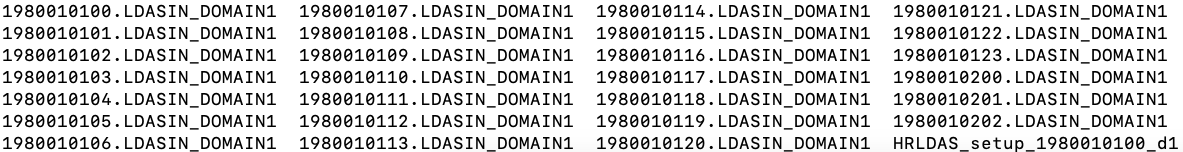

## 4. Running regional simulation with ERA5-Land forcing


### 4.1 Modify namelist
Similar to editing the namelist for single-point simulation, we can now edit the namelist for PPR simulaiton with ERA5-Land forcing:

`cd ./hrldas/hrldas/run/` # get into the hrldas run directory

`cp examples/ERA5/namelist.hrldas.ERA5 namelist.hrldas`
Edit the namelist file: `namelist.hrldas`

`HRLDAS_SETUP_FILE = "../../../ERA5_Land/LDASIN1980/HRLDAS_setup_1980010100_d1"`

`INDIR = "../../../ERA5_Land/LDASIN1980/"`

`OUTDIR = "../../../ERA5_Land/LDASOU1980/"`
 
**Note** remember to change the forcing, model, and output timestep for one hour (3600s):

`FORCING_TIMESTEP = 3600`

`NOAH_TIMESTEP    = 3600`

`OUTPUT_TIMESTEP  = 3600`

**Note** the newest version HRLDAS can cope with different soil layer thickness, so don't need to change soil thickness:
https://github.com/NCAR/hrldas/commit/ba09bf052c22f1e0fcbb93065998f3903ce2c033


### 4.2 Execute the model
You can either submit the regional simulation at login node. Since we only run the model for three day, it wouldn't take so long (about 5-min). 

`./hrldas.exe`

For a larger domain and longer simulation time, it is encouraged to submit jobs to supercomputer, e.g. Cheyenne. We can prepare a job submission script called `runhrldas.csh`

`qsub runhrldas.csh` 


After executing the model run, we can view model runtime printed on the screen: 
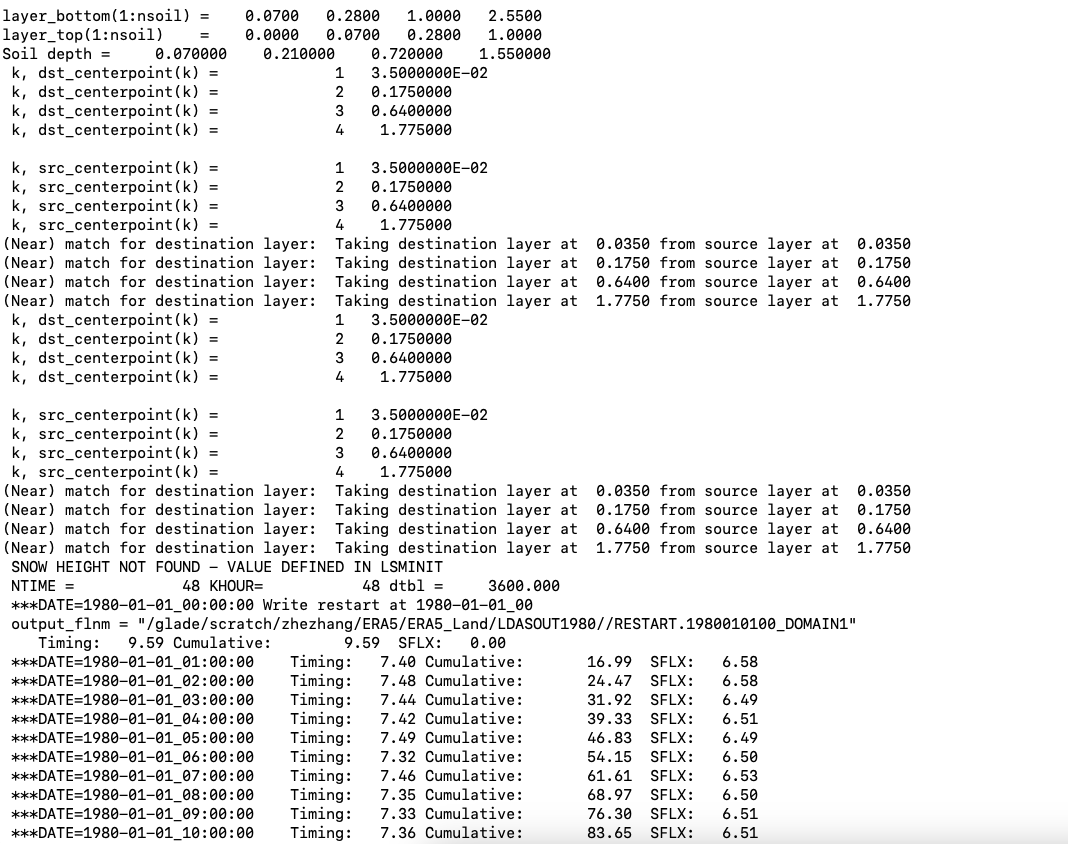
......


### 4.3 Check model outputs
We can quickly view model output using `ncview`:
For the first day results:

`ncview 1980010101.LDASOUT_DOMAIN1`

For example, if we want to view the `T2` hourly results, here is an gif animation:

To calculate `T2` temperature, we will need to calculate the weighted average of T2MV and T2MB.

T2 = FVEG * T2MV + (1-FVEG) * T2MB

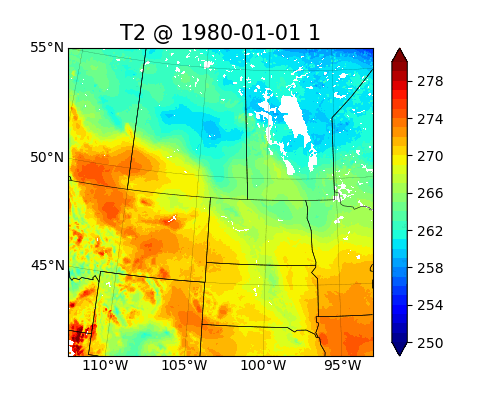

### Congratulations, you have successfully running the ERA5-Land data over the Prairie Pothole Region!